Trabajo ejemplo tomado del curso de inteligencia artificial IA2023I. El ejemplo está construido con un conjunto de datos disponible en Kaggle: https://www.kaggle.com/datasets/ulrikthygepedersen/rotten-tomatoes-reviews

# Descripción del problema

En el presente trabajo se predente analizar las opiniones de peliculas de la plataforma Rotten Tomatoes, aqui se pueden observar 
las opiniones que realizan los usuarios que son clasificadas en dos categorias "Rotten" y "Fresh".

<font color="red">Rotten Tomatoes:</font>, es un sitio web que se dedica a recopilar y sintetizar reseñas de películas y programas de televisión.

Objetivos específicos:


*   Implementar los modelos de aprendizaje de máquina: árboles de decisión,random forest, redes neunales y redes neuronales profundas.
*   Realizar análisis y pruebas con el dataset suministrado de Kaggle.

*  Aplicar ténicas de procesamiento al conjunto de datos. 



### Descripción de variables:

El conjunto de datos tomado de Kaggle es un datasets que está conformado por dos columnas la primera conluna se llama Freshness y la segunda Review.

*   La variable objetivo es <font color="red">Y</font>, que corresponde a la columna 'Freshness' del DataFrame df. Esta columna contiene la etiqueta de frescura ('rotten' o 'fresh') asociada a cada comentario.

*  La variable predictora <font color="red">X</font>, que corresponde a la columna 'Review' del DataFrame df. Esta columna contiene los comentarios de los usuarios.


### Librerias utilizadas

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [11]:
# Tratamiento de datos

!pip install unidecode

import numpy as np
import pandas as pd
import string
import re
import nltk
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import VarianceThreshold
from scipy.spatial.distance import cosine
from unidecode import unidecode
from sklearn.tree import plot_tree

# Gráficos
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
from wordcloud import WordCloud

# Preprocesado y modelado
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score


# Configuración warnings
import warnings
warnings.filterwarnings('ignore')
import nltk
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

### Cargando el datasets

In [4]:
# Ruta del archivo CSV en Google Drive
rt_reviews = "/content/drive/MyDrive/Colab Notebooks/prueba/rt_reviews.csv"


# Leer el archivo CSV en un DataFrame
df = pd.read_csv(rt_reviews, encoding='ISO-8859-1', nrows=100000)

# Verificar que los datos se hayan cargado correctamente
print(df.head())


  Freshness                                             Review
0     fresh   Manakamana doesn't answer any questions, yet ...
1     fresh   Wilfully offensive and powered by a chest-thu...
2    rotten   It would be difficult to imagine material mor...
3    rotten   Despite the gusto its star brings to the role...
4    rotten   If there was a good idea at the core of this ...


Se muestran las colunmas de datasets

In [5]:
df[['Freshness','Review']].head()

,Freshness,Review
0,fresh,"Manakamana doesn't answer any questions, yet ..."
1,fresh,Wilfully offensive and powered by a chest-thu...
2,rotten,It would be difficult to imagine material mor...
3,rotten,Despite the gusto its star brings to the role...
4,rotten,If there was a good idea at the core of this ...


Se cuentan el numero de filas del Datasets


In [6]:
# Contar el total de filas
total_filas = df.shape[0]

print("Total de filas:", total_filas)

Total de filas: 100000


Se muestra la cantidad de datos para entrenamiento y prueba

En las siguientes gráfica de barras se puede apreciar el balaceo de los datos en la categorias Rotten de color Rojo y Fresh verde. Ambas categorías tienen los mismo comentarios.

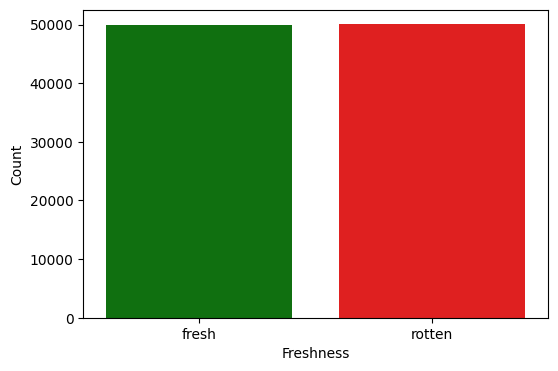

In [7]:
# Establecer el tamaño de la figura
plt.figure(figsize=(6, 4))

# Crear un countplot con las categorías "rotten" y "freshness" de diferentes colores
sns.countplot(data=df, x='Freshness', palette={'rotten': 'red', 'fresh': 'green'})

# Configurar los ejes y etiquetas
plt.xlabel('Freshness')
plt.ylabel('Count')

# Mostrar el gráfico
plt.show()


# Análisis exploratorio🔎 

En siguiente análisis se realizaron consideraron las sguientes tareas a realizar:

*   Convierte todo el texto a minúsculas.
*   Elimina signos de puntuación utilizando expresiones regulares.
*   Elimina espacios en blanco múltiples reemplazándolos por un solo espacio.
*   eliminación adicional de palabras no deseadas como preposiciones, pronombres y stopwords. 
*   Elimina tokens con una longitud menor a 2, es decir, elimina palabras 
*   Elemento de la lista individuales que son demasiado cortas.
*   Eliminar fechas








Se eliminan las preposiciones y los pronombres de una lista de tokens de texto en inglés

In [8]:
def remove_pos(tokens):
    # Obtener la lista de stopwords (incluye preposiciones) en inglés
    stopwords = set(nltk.corpus.stopwords.words('english'))
    
    pronouns = set()
    tagged_words = pos_tag(stopwords)
    for word, tag in tagged_words:
        if tag.startswith('PRP'):
            pronouns.add(word)
    
    tagged_tokens = pos_tag(tokens)
    tokens_without_pos = [token[0] for token in tagged_tokens if token[0] not in stopwords and token[0] not in pronouns]
    
    return tokens_without_pos


Esta función toma un texto, realiza las de operaciones de limpieza 

### Tokenizacón y limpieza de datos 

In [9]:
def limpiar_tokenizar(texto, remove_pos):
    # Crear instancia del lematizador
    lemmatizer = WordNetLemmatizer()
    
    nuevo_texto = texto.lower()
    # Eliminación de signos de puntuación
    regex = '[\\!\\"\\#\\$\\%\\&\\\'\\(\\)\\*\\+\\,\\-\\.\\/\\:\\;\\<\\=\\>\\?\\@\\[\\\\\\]\\^_\\`\\{\\|\\}\\~]'
    nuevo_texto = re.sub(regex , ' ', nuevo_texto)
    # Eliminación de números
    nuevo_texto = re.sub("\d+", ' ', nuevo_texto)
    # Eliminación de espacios en blanco múltiples
    nuevo_texto = re.sub("\\s+", ' ', nuevo_texto)
    # Eliminación de diéresis
    nuevo_texto = unidecode(nuevo_texto)
    # Eliminación de fracciones
    nuevo_texto = re.sub("\d+/\d+", ' ', nuevo_texto)
    # Eliminación de fechas
    nuevo_texto = re.sub("\d{1,2}/\d{1,2}/\d{2,4}", ' ', nuevo_texto)
    # Tokenización por palabras individuales
    nuevo_texto = nuevo_texto.split(sep=' ')
    # Eliminar preposiciones, pronombres y stopWords
    nuevo_texto = remove_pos(nuevo_texto)
    # Lematización
    nuevo_texto = [lemmatizer.lemmatize(token) for token in nuevo_texto]
    # Eliminación de tokens con una longitud < 2
    nuevo_texto = [token for token in nuevo_texto if len(token) > 1]
    
    return nuevo_texto

Este código toma los valores de la columna 'Review' en el DataFrame 'df', los limpia y tokeniza utilizando la función 'limpiar_tokenizar', y luego asigna los resultados a la columna 'texto_tokenizado'

In [12]:
df['texto_tokenizado'] = df['Review'].apply(lambda x: limpiar_tokenizar(x, remove_pos))


In [13]:
df[['Freshness','Review','texto_tokenizado']].to_csv('resultadoTokeniz.csv', index=False)

Estas operaciones están transformando el DataFrame 'df' en un nuevo DataFrame 'texto_tidy' donde cada token se coloca en una fila separada y la columna correspondiente se llama 'token'.

In [14]:
texto_tidy =df.explode(column='texto_tokenizado')
texto_tidy= texto_tidy.drop(columns='Review')
texto_tidy= texto_tidy.rename(columns={'texto_tokenizado':'token'})
texto_tidy.head(10)

,Freshness,token
0,fresh,manakamana
0,fresh,answer
0,fresh,question
0,fresh,yet
0,fresh,make
0,fresh,point
0,fresh,nepal
0,fresh,like
0,fresh,rest
0,fresh,planet


En este bloque de código se implementa una nube de palabras donde se puede evidenciar las palabras más constantes.

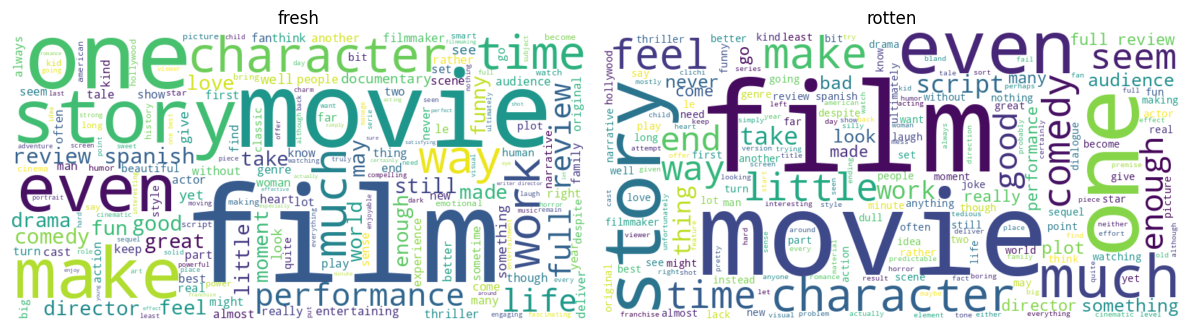

In [15]:
# Import the required libraries
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Convert float items to strings in the palabras list
palabras_por_categoria = texto_tidy.groupby('Freshness')['token'].apply(lambda x: [str(word) for word in x])

# Create an instance of WordCloud for each category and generate the word cloud
wordclouds = {}
for categoria, palabras in palabras_por_categoria.items():
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(palabras))
    wordclouds[categoria] = wordcloud

# Display the word clouds for each category
plt.figure(figsize=(12, 6))
for i, (categoria, wordcloud) in enumerate(wordclouds.items()):
    plt.subplot(1, 2, i+1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(categoria)
    plt.axis('off')
plt.tight_layout()
plt.show()


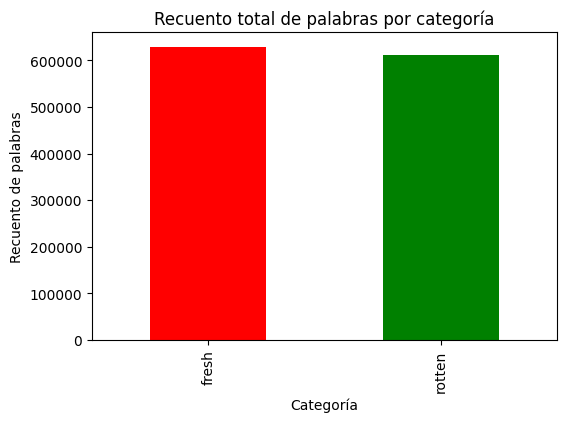

--------------------------
Palabras totales por categoría 👇
--------------------------


Freshness
fresh     629269
rotten    611926
Name: token, dtype: int64

In [16]:
#@title Recuento total de palabras por categoría
word_count = texto_tidy.groupby('Freshness')['token'].count()

# Crear la tabla gráfica
fig, ax = plt.subplots(figsize=(6, 4))
colors = ['red', 'green']  # Colores para las categorías 'rotten' y 'fresh'
word_count.plot(kind='bar', ax=ax, color=colors)
ax.set_xlabel('Categoría')
ax.set_ylabel('Recuento de palabras')
ax.set_title('Recuento total de palabras por categoría')

# Mostrar la tabla gráfica
plt.show()

print('--------------------------')
print('Palabras totales por categoría 👇')
print('--------------------------')
texto_tidy.groupby(by='Freshness')['token'].count()


Aquí podemos la cantidad de palabras en las categorías rotten y fresh.

### Conteo de palabras distintas 

In [17]:
# Palabras distintas utilizadas 
# ==============================================================================
print('----------------------------')
print('Palabras distintas por categoria')
print('----------------------------')
texto_tidy.groupby(by='Freshness')['token'].nunique()

----------------------------
Palabras distintas por categoria
----------------------------


Freshness
fresh     35200
rotten    35036
Name: token, dtype: int64

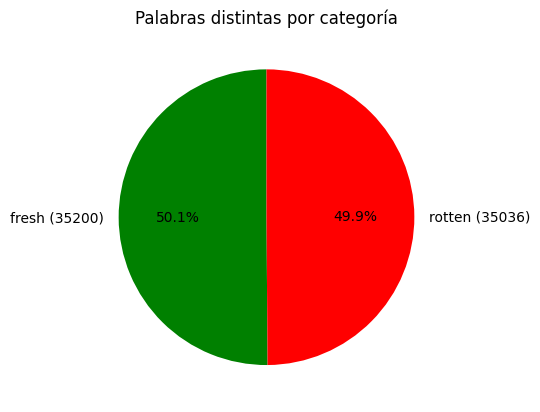

In [18]:
#@title Gráfico porcentaje de palabras distintas por categoría
unique_words = texto_tidy.groupby('Freshness')['token'].nunique()

# Definir los colores de las categorías
colors = ['green', 'red']

# Crear el gráfico de pastel
fig, ax = plt.subplots()
patches, texts, autotexts = ax.pie(unique_words, labels=unique_words.index, autopct='%1.1f%%', startangle=90, colors=colors)

# Agregar los valores numéricos junto a las etiquetas
for i, label in enumerate(texts):
    percentage = label.get_text()
    count = unique_words[i]
    label.set_text(f'{percentage} ({count})')

ax.set_title('Palabras distintas por categoría')

# Mostrar el gráfico de pastel
plt.show()


Aqui podemos ver el porcentaje de palabras por cada categoría.

### Número de palabras comunes entre categorías

In [19]:
# ==============================================================================
palabras_rotten = set(texto_tidy[texto_tidy.Freshness == 'fresh']['token'])
palabras_fresh = set(texto_tidy[texto_tidy.Freshness == 'rotten']['token'])


print(f"Palabras comunes entre Rotten y fresh: {len(palabras_rotten.intersection(palabras_fresh))}")


Palabras comunes entre Rotten y fresh: 23368


In [20]:
palabras_comunes = palabras_rotten.intersection(palabras_fresh)
palabras_comunes_lista = list(palabras_comunes)

df_palabras_comunes = pd.DataFrame(palabras_comunes_lista, columns=['Palabra'])
df_palabras_comunes.to_csv('palabras_comunes.csv', index=False)



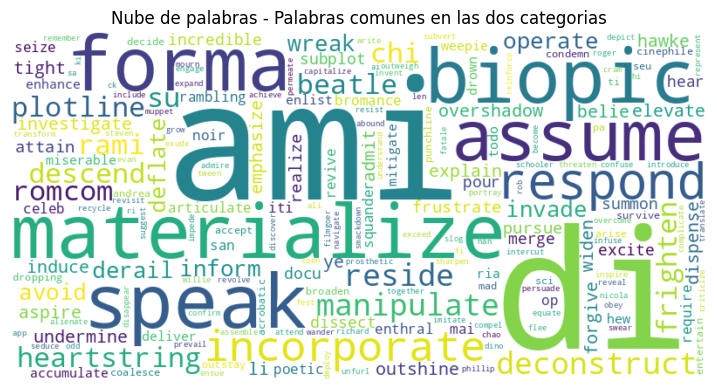

In [21]:
#@title Nube las palabras comunes en las dos categorias
# Convertir los elementos de palabras_comunes a cadenas de texto
palabras_comunes_str = [str(palabra) for palabra in palabras_comunes]

# Crear una cadena de texto con las palabras comunes
texto_comun = ' '.join(palabras_comunes_str)

# Crear el objeto WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(texto_comun)

# Mostrar la nube de palabras
plt.figure(figsize=(9, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de palabras - Palabras comunes en las dos categorias')
plt.show()


### Comparación en el uso de palabras

 Se calcula el log odds ratio de cada palabra en los comentarios y determina si una palabra es más frecuente en la categoría rotten o fresh. Luego, muestra las 10 palabras más diferenciadoras en función del valor absoluto del log odds.

En el DataFrame mostrado, representan lo siguiente:



1.   <font color="color">rotte & fresh:</font> La probabilidad estimada de que la palabra aparezca en la categoría rotten y fresh
2.   <font color="color">log_odds:</font> El logaritmo de la razón de probabilidades (log odds ratio) de la palabra entre las categorías "rotten" y "fresh".

3. <font color="color">abs_log_odds:</font> Este valor representa la magnitud de la diferencia en la probabilidad de la palabra entre las categorías.
4.    <font color="color">categoria frecuente:</font>  La categoría en la que la palabra es más frecuente según el log odds ratio. "rotten" indica que la palabra es más frecuente en la categoría "rotten", y "fresh" indica que es más frecuente en la categoría "fresh".

Los valores positivos indican una asociación más fuerte con la categoría "fresh", mientras que los valores negativos indican una asociación más fuerte con la categoría "rotten". 








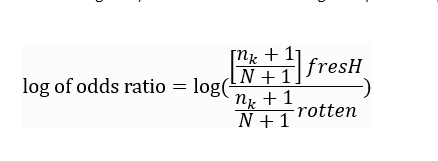



Una forma de hacer este análisis es mediante el log of odds ratio de las frecuencias. Esta comparación se hace por pares, en este caso se comparan Rotten y fresh.

siendo  nk el número de veces que aparece el término k en los textos de cada categoria y  N  el número total de términos de cada usuario.

In [22]:
# Cálculo del log of odds ratio de cada palabra (rotten vs fresh)
# ==============================================================================
# Pivotaje y despivotaje
comentarios_pivot = texto_tidy.groupby(["Freshness","token"])["token"] \
                .agg(["count"]).reset_index() \
                .pivot(index = "token" , columns="Freshness", values= "count")

comentarios_pivot = comentarios_pivot.fillna(value=0)
comentarios_pivot.columns.name = None

comentarios_unpivot = comentarios_pivot.melt(value_name='n', var_name='Freshness', ignore_index=False)
comentarios_unpivot = comentarios_unpivot.reset_index()

# Selección de las categorias rotten y fresh
comentarios_unpivot = comentarios_unpivot[comentarios_unpivot.Freshness.isin(['rotten', 'fresh'])]

# Se añade el total de palabras de cada categoria
comentarios_unpivot = comentarios_unpivot.merge(
                    texto_tidy.groupby('Freshness')['token'].count().rename('N'),
                    how = 'left',
                    on  = 'Freshness'
                 )

# Cálculo de odds y log of odds de cada palabra
comentarios_logOdds = comentarios_unpivot.copy()
comentarios_logOdds['odds'] = (comentarios_logOdds.n + 1) / (comentarios_logOdds.N + 1)
comentarios_logOdds = comentarios_logOdds[['token', 'Freshness', 'odds']] \
                    .pivot(index='token', columns='Freshness', values='odds')
comentarios_logOdds.columns.name = None

comentarios_logOdds['log_odds']     = np.log(comentarios_logOdds.rotten/comentarios_logOdds.fresh)
comentarios_logOdds['abs_log_odds'] = np.abs(comentarios_logOdds.log_odds)

# Si el logaritmo de odds es mayor que cero, significa que es una palabra con
# mayor probabilidad de ser de rotten. Esto es así porque el ratio se ha
# calculado como rotten/fresh.
comentarios_logOdds['categoria frecuente'] = np.where(comentarios_logOdds.log_odds > 0,
                                              "fresh",
                                              "rotten"
                                    )

Permite identificar las palabras que tienen una mayor probabilidad de pertenecer a una categoría en comparación con la otra.

In [23]:
print('-----------------------------------')
print('Top 10 palabras más diferenciadoras')
print('-----------------------------------')
comentarios_logOdds.sort_values('abs_log_odds', ascending=False).head(10)

-----------------------------------
Top 10 palabras más diferenciadoras
-----------------------------------


,fresh,rotten,log_odds,abs_log_odds,categoria frecuente
token,,,,,
witless,0.000002,0.000134,4.434667,4.434667,fresh
joyless,0.000002,0.000109,4.232640,4.232640,fresh
charmless,0.000002,0.000090,4.035281,4.035281,fresh
lazily,0.000002,0.000069,3.765617,3.765617,fresh
jumbled,0.000002,0.000059,3.611466,3.611466,fresh
unfunny,0.000011,0.000381,3.533076,3.533076,fresh
squanders,0.000003,0.000096,3.412338,3.412338,fresh
abysmal,0.000002,0.000047,3.395243,3.395243,fresh
tepid,0.000005,0.000132,3.323784,3.323784,fresh


Text(0.5, 0, 'log odds ratio (rotten / fresh)')

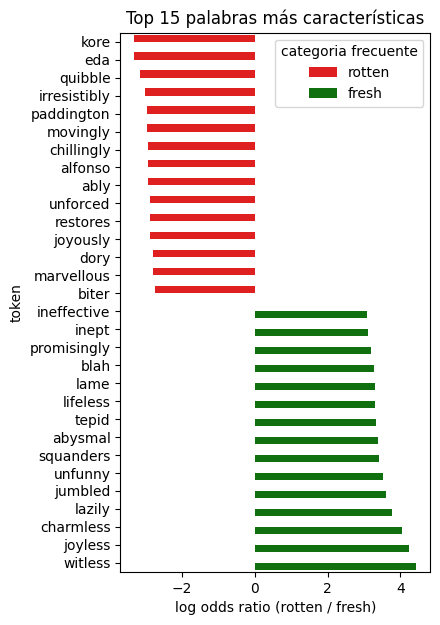

In [24]:
#@title Top 15 palabras más características de cada categoria
# ==============================================================================

top_30 = comentarios_logOdds[['log_odds', 'abs_log_odds', 'categoria frecuente']] \
        .groupby('categoria frecuente') \
        .apply(lambda x: x.nlargest(15, columns='abs_log_odds').reset_index()) \
        .reset_index(drop=True) \
        .sort_values('log_odds')

f, ax = plt.subplots(figsize=(4, 7))
sns.barplot(
    x='log_odds',
    y='token',
    hue='categoria frecuente',
    data=top_30,
    ax=ax,
    palette={'rotten': 'red', 'fresh': 'green'}  # Cambiar los colores aquí
)
ax.set_title('Top 15 palabras más características')
ax.set_xlabel('log odds ratio (rotten / fresh)')

### Term Frequency e Inverse Document Frequency

Permite calcular la frecuencia relativa de cada término en el texto mediante el cálculo del Term Frequency (tf).

In [25]:
# Cálculo term-frecuency (tf)
# ==============================================================================
tf = texto_tidy.copy()
# Número de veces que aparece cada término en cada comentario
tf = tf.groupby(["token"])["token"].agg(["count"]).reset_index()
# Se añade una columna con el total de términos por comentario
tf['total_count'] = tf.groupby('token')['count'].transform(sum)
# Se calcula el tf
tf['tf'] = tf["count"] / tf["total_count"]
tf.sort_values(by = "tf").head(5)

,token,count,total_count,tf
0,aa,1,1,1.0
31241,plugged,14,14,1.0
31242,plugging,2,2,1.0
31243,plum,9,9,1.0
31244,plumage,1,1,1.0


Se calcula el IDF para cada término en el conjunto de texto, lo cual es útil para determinar la importancia relativa de cada término.

In [26]:
# Inverse document frequency
# ==============================================================================
idf = texto_tidy.copy()
total_documents = idf["token"].drop_duplicates().count()
# Número de comentarios en los que aparece cada término
idf = idf.groupby(["token"])["token"].agg(["count"]).reset_index()
idf[' n_comentarios'] = idf.groupby('token')['count'].transform(sum)
# Cálculo del idf
idf['idf'] = np.log(total_documents / idf[' n_comentarios'])
idf = idf[["token"," n_comentarios", "idf"]].drop_duplicates()
idf.sort_values(by="idf").head(3)

,token,n_comentarios,idf
15069,film,18415,0.934191
27068,movie,14650,1.162916
28853,one,8655,1.689219


 En esta tabla podemos observa el número de comentaroosn_comentarios" refleja el número de comentarios en los que aparece cada término.

Term Frequency - Inverse Document Frequency:


La razón principal para realizar este cálculo es identificar los términos más relevantes y distintivos en un conjunto de documentos.


### Creación de la matriz tf-idf


In [27]:
# Term Frequency - Inverse Document Frequency
# ==============================================================================
tf_idf = pd.merge(left=tf, right=idf, on="token")
tf_idf["tf_idf"] = tf_idf["tf"] * tf_idf["idf"]
tf_idf.sort_values(by="token").head()

,token,count,total_count,tf,n_comentarios,idf,tf_idf
0,aa,1,1,1.0,1,10.755112,10.755112
1,aaaarrrrggghh,1,1,1.0,1,10.755112,10.755112
2,aaack,1,1,1.0,1,10.755112,10.755112
3,aah,2,2,1.0,2,10.061965,10.061965
4,aahing,1,1,1.0,1,10.755112,10.755112


### División de datos 

Dividir los datos en conjuntos de entrenamiento y prueba (por ejemplo, 20% entrenamiento, 80% prueba)

In [39]:
"""import pandas as pd

# Especificar la ruta del archivo CSV
ruta_archivo = r'C:\Users\Ingris\Downloads\Prueba ML\240julioTokenizado.csv'

# Leer el archivo CSV
df = pd.read_csv(ruta_archivo, nrows=100000)

# Acceder a los datos de las columnas
freshness = df['Freshness']
review = df['Review']
texto_tokenizado = df['texto_tokenizado']

df.head()


,Freshness,Review,texto_tokenizado
0,fresh,"Manakamana doesn't answer any questions, yet ...","['manakamana', 'answer', 'question', 'yet', 'm..."
1,fresh,Wilfully offensive and powered by a chest-thu...,"['wilfully', 'offensive', 'powered', 'chest', ..."
2,rotten,It would be difficult to imagine material mor...,"['would', 'difficult', 'imagine', 'material', ..."
3,rotten,Despite the gusto its star brings to the role...,"['despite', 'gusto', 'star', 'brings', 'role',..."
4,rotten,If there was a good idea at the core of this ...,"['good', 'idea', 'core', 'film', 'buried', 'un..."


In [42]:
import pandas as pd
from sklearn.model_selection import train_test_split

datos_X = df['texto_tokenizado']
datos_y = df['Freshness']

print(datos_X.unique())
print(datos_y.unique())

X_train, X_test, y_train, y_test = train_test_split(
    datos_X,
    datos_y,
    test_size=0.80,
    random_state=42
)

#con 80% para prueba 71%
#con 33% test da  75%

["['manakamana', 'answer', 'question', 'yet', 'make', 'point', 'nepal', 'like', 'rest', 'planet', 'picturesque', 'far', 'peaceable', 'kingdom']"
 "['wilfully', 'offensive', 'powered', 'chest', 'thumping', 'machismo', 'good', 'clean', 'fun']"
 "['would', 'difficult', 'imagine', 'material', 'wrong', 'spade', 'lost', 'found']"
 ... "['definitely', 'planet', 'worth', 'visit']"
 "['film', 'could', 'used', 'educational', 'tool', 'government', 'unconvinced', 'importance', 'effective', 'social', 'support', 'network']"
 "['fabulous', 'maleficent', 'look', 'fabulous', 'film', 'sacrifice', 'story', 'design']"]
['fresh' 'rotten']


Transformación de los datos de entrenamiento y prueba:

### Vectorización

In [43]:
from sklearn.feature_extraction.text import CountVectorizer

# Crear una instancia del vectorizador
vectorizer = CountVectorizer()

# Ajustar el vectorizador con los datos de entrenamiento
Xtrain = vectorizer.fit_transform(X_train)

# Transformar los datos de prueba utilizando el vectorizador ajustado
Xtest = vectorizer.transform(X_test)

print(Xtrain.shape)

(20000, 25266)


In [44]:
tokens = vectorizer.get_feature_names_out()
print("Tokens:", tokens)

print("Tokens:", len(tokens))

Tokens: ['aahing' 'aamir' 'aarav' ... 'zwart' 'zweig' 'zwick']
Tokens: 25266


In [45]:
print("Conjunto de entrenamiento - Características:", Xtrain.shape)
print("Conjunto de entrenamiento - Etiquetas:", y_train.shape)
print("Conjunto de prueba - Características:", Xtest.shape)
print("Conjunto de prueba - Etiquetas:", y_test.shape)

Conjunto de entrenamiento - Características: (20000, 25266)
Conjunto de entrenamiento - Etiquetas: (20000,)
Conjunto de prueba - Características: (80000, 25266)
Conjunto de prueba - Etiquetas: (80000,)


 # Funciones de selección de caracteristicas

In [46]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.datasets import make_classification

def cuasiConstantes(Xtrain, Xtest, threshold=0.02):
    # Crear el objeto VarianceThreshold
    selector = VarianceThreshold(threshold=threshold)

    # Aplicar la eliminación de características cuasi-constantes en la matriz tf-idf de entrenamiento
    xtrain = selector.fit_transform(Xtrain)

    # Obtener los índices de las características seleccionadas
    selected_feature_indices = selector.get_support(indices=True)

    # Filtrar la matriz tf-idf de prueba utilizando los índices de características seleccionadas
    xtest = selector.transform(Xtest)

    num_selected_features = xtrain.shape[1]
    print("Número de características seleccionadas:", num_selected_features)

    return xtrain, xtest, selected_feature_indices


def ScaracteristicasRandom(xtrain, y_train, n_estimators=100, max_depth=None, min_samples_split=2):
    # Crear un estimador Random Forest con parámetros ajustados
    rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, n_jobs=-1)

    # Crear un selector RFE con Random Forest y ranking
    rfe = RFE(estimator=rf, step=2)

    # Aplicar RFE al conjunto de datos
    xtrainE = rfe.fit_transform(xtrain, y_train)
    # Obtener las características seleccionadas
    selected_features = rfe.support_

    # Obtener el ranking de importancia de características
    feature_ranking = rfe.ranking_

    # Imprimir las características seleccionadas
    print("Características seleccionadas:")
    for i, feature in enumerate(selected_features):
        if feature:
            print(f"Feature {i+1}")

    # Imprimir el ranking de características
    print("Ranking de características :")
    for i, rank in enumerate(feature_ranking):
        print(f"Feature {i+1}: {rank}")
        


    return xtrainE, selected_features, feature_ranking


In [47]:
from sklearn.feature_selection import VarianceThreshold
xtrain, xtest, selected_feature_indices=cuasiConstantes(Xtrain, Xtest)
#num_selected_features = xtrain.shape[1]

Número de características seleccionadas: 58


In [48]:
xtrainE, selected_features, feature_ranking = ScaracteristicasRandom(xtrain, y_train)
xtestE = xtest[:, selected_features]  # Conjunto de prueba transformado

Características seleccionadas:
Feature 1
Feature 3
Feature 4
Feature 6
Feature 7
Feature 13
Feature 14
Feature 15
Feature 16
Feature 17
Feature 21
Feature 23
Feature 26
Feature 30
Feature 31
Feature 32
Feature 33
Feature 35
Feature 36
Feature 37
Feature 38
Feature 40
Feature 41
Feature 44
Feature 46
Feature 48
Feature 50
Feature 52
Feature 54
Ranking de características :
Feature 1: 1
Feature 2: 15
Feature 3: 1
Feature 4: 1
Feature 5: 4
Feature 6: 1
Feature 7: 1
Feature 8: 3
Feature 9: 10
Feature 10: 6
Feature 11: 13
Feature 12: 7
Feature 13: 1
Feature 14: 1
Feature 15: 1
Feature 16: 1
Feature 17: 1
Feature 18: 5
Feature 19: 16
Feature 20: 14
Feature 21: 1
Feature 22: 6
Feature 23: 1
Feature 24: 14
Feature 25: 10
Feature 26: 1
Feature 27: 5
Feature 28: 8
Feature 29: 12
Feature 30: 1
Feature 31: 1
Feature 32: 1
Feature 33: 1
Feature 34: 7
Feature 35: 1
Feature 36: 1
Feature 37: 1
Feature 38: 1
Feature 39: 8
Feature 40: 1
Feature 41: 1
Feature 42: 13
Feature 43: 16
Feature 44: 1
Feature 4

In [49]:
# Contar características seleccionadas
num_selected_features = sum(selected_features)
print("Número de características seleccionadas:", num_selected_features)

Número de características seleccionadas: 29


# Modelos de aprendizaje de máquina 🤖

A patir de de este bloque de código se inicia con la implementación de los modelos:

 * Random Forest
 * Árboles de decisión
 * Redes neuronales
 * Redes neuronales profundas
 
 En cada método hacemos una prueba sin selección de carácteristica, usando Feature cuasi-Contantes y Random forest FRE.

## Random forest 

### Pruebas para random con parámetros por defecto.

In [50]:
# Crear el modelo de Random Forest
modelo_rf = RandomForestClassifier(n_estimators=100, random_state=42)

print("Dimensiones entreamiento :", xtrain.shape)
print("Dimensiones prueba ", y_train.shape)

Dimensiones entreamiento : (20000, 58)
Dimensiones prueba  (20000,)


In [51]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

rf_Model = RandomForestClassifier()
cross_val_scores = cross_val_score(rf_Model, Xtrain, y_train, cv=2)
rf_Model.fit(Xtrain, y_train)
# Evaluar el rendimiento del modelo en los datos de entrenamiento y prueba
train_accuracy = rf_Model.score(Xtrain, y_train) * 100
test_accuracy = rf_Model.score(Xtest, y_test) * 100

print("Precisión del entrenamiento:", "{:.3f}%".format(train_accuracy))
print("Precisión de prueba:", "{:.3f}%".format(test_accuracy))


Precisión del entrenamiento: 99.975%
Precisión de prueba: 71.395%


In [52]:
# Imprimir los resultados de la validación cruzada
print("Resultados de la validación cruzada:")
print(cross_val_scores)
print("Precisión media: {:.2f}".format(cross_val_scores.mean()))

Resultados de la validación cruzada:
[0.6936 0.7057]
Precisión media: 0.70


### Prueba con Hiperámetros y feature cuasi-constante

In [53]:
# Crear el modelo de Random Forest
modelo_rf = RandomForestClassifier(n_estimators=100, random_state=42)

print("Dimensiones entreamiento :", xtrain.shape)
print("Dimensiones prueba ", y_train.shape)


Dimensiones entreamiento : (20000, 58)
Dimensiones prueba  (20000,)


Descripción de parámetros:

**n_estimators:** Representa el número de árboles de decisión que se van a utilizar en el modelo.

**start:** Es el valor de inicio para la secuencia de números generada. 

**stop:** Es el valor final de la secuencia de números generada.

**num:** Es el número de valores que se generarán en la secuencia. 


In [54]:
# Número de árboles en el bosque aleatorio
n_estimators = [int(x) for x in np.linspace(start=150, stop=400, num=4)]
# Número de características a considerar en cada división
max_features = ['auto', 'sqrt']
# Número máximo de niveles en el árbol
max_depth = None,
# Número mínimo de muestras requeridas para dividir un nodo
min_samples_split = [5, 10]
# Número mínimo de muestras requeridas en cada nodo hoja
min_samples_leaf = [1, 2]
# Método de selección de muestras para entrenar cada árbol

Creación de un objeto GridSearchCV y su posterior ajuste utilizando un modelo RandomForestClassifier en conjunto con una cuadrícula de hiperparámetros especificada en param_grid

In [55]:
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,              
                }
print(param_grid)

{'n_estimators': [150, 233, 316, 400], 'max_features': ['auto', 'sqrt'], 'max_depth': (None,), 'min_samples_split': [5, 10], 'min_samples_leaf': [1, 2]}


Se crea una instancia del clasificador RandomForestClassifier.

In [56]:
rf_Grid = GridSearchCV(estimator = rf_Model, param_grid = param_grid, cv = 2, verbose=2, n_jobs = 4)


In [57]:
rf_Grid.fit(xtrain, y_train)

Fitting 2 folds for each of 32 candidates, totalling 64 fits


GridSearchCV(cv=2, estimator=RandomForestClassifier(), n_jobs=4,
             param_grid={'max_depth': (None,), 'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [5, 10],
                         'n_estimators': [150, 233, 316, 400]},
             verbose=2)

In [58]:
rf_Grid.best_params_

{'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 316}

In [59]:
# Evaluar el rendimiento del modelo en los datos de entrenamiento y prueba
train_accuracy = rf_Grid.score(xtrain, y_train) * 100
test_accuracy = rf_Grid.score(xtest, y_test) * 100

In [60]:
print("Precisión del entrenamiento:", "{:.3f}%".format(train_accuracy))
print("Precisión de prueba:", "{:.3f}%".format(test_accuracy))

Precisión del entrenamiento: 66.805%
Precisión de prueba: 57.627%


###  Prueba con selección de caracteristicas Random FRE

In [61]:
# Contar características seleccionadas
num_selected_features = sum(selected_features)
print("Número de características seleccionadas:", num_selected_features)

Número de características seleccionadas: 29


In [62]:
# Crear el modelo de Random Forest
modelo_rf = RandomForestClassifier(n_estimators=100, random_state=42)

print("Dimensiones :", xtrainE.shape)
print("Dimensiones ", y_train.shape)

Dimensiones : (20000, 29)
Dimensiones  (20000,)


In [63]:
# Número de árboles en el bosque aleatorio
n_estimators = [int(x) for x in np.linspace(start=100, stop=150, num=3)]
#Número de características a considerar en cada división
max_features = ['auto', 'sqrt']
# Número máximo de niveles en el árbol
max_depth = [2, 4]
# Número mínimo de muestras requeridas para dividir un nodo
min_samples_split = [2, 5]
# Número mínimo de muestras requeridas en cada nodo hoja
min_samples_leaf = [1, 2]


In [64]:
param_grid = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
}

print(param_grid)

{'n_estimators': [100, 125, 150], 'max_features': ['auto', 'sqrt'], 'max_depth': [2, 4], 'min_samples_split': [2, 5], 'min_samples_leaf': [1, 2]}


In [65]:
rf_Grid = GridSearchCV(estimator = rf_Model, param_grid = param_grid, cv = 2, verbose=2, n_jobs = 4)

In [66]:
rf_Grid.fit(xtrainE, y_train)

Fitting 2 folds for each of 48 candidates, totalling 96 fits


GridSearchCV(cv=2, estimator=RandomForestClassifier(), n_jobs=4,
             param_grid={'max_depth': [2, 4], 'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 125, 150]},
             verbose=2)

In [67]:
rf_Grid.best_params_

{'max_depth': 4,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 150}

In [68]:
# Evaluar el rendimiento del modelo en los datos de entrenamiento y prueba
train_accuracy = rf_Grid.score(xtrainE, y_train) * 100
test_accuracy = rf_Grid.score(xtestE, y_test) * 100

In [69]:
print("Precisión del entrenamiento:", "{:.3f}%".format(train_accuracy))
print("Precisión de prueba:", "{:.3f}%".format(test_accuracy))

Precisión del entrenamiento: 54.955%
Precisión de prueba: 54.054%


### Matriz de confusión prueba adicional

A continuación se realizan tres pruebas con diferentes hiperparámetros para revisar la precisión en cada prueba y lograr mejores resultados que la prueba inicial.

In [70]:
param_sets = [
    {'n_estimators': 30, 'min_samples_split': 15,'min_samples_leaf': 15,'max_depth': 28, 'max_features': 'auto'},
]


Número de prueba: 1
Parámetros: {'n_estimators': 30, 'min_samples_split': 15, 'min_samples_leaf': 15, 'max_depth': 28, 'max_features': 'auto'}
Precisión de entrenamiento: 59.65%
Precisión de prueba: 57.89%
Tiempo de ejecución : 0.9 segundos
--------------------------------------


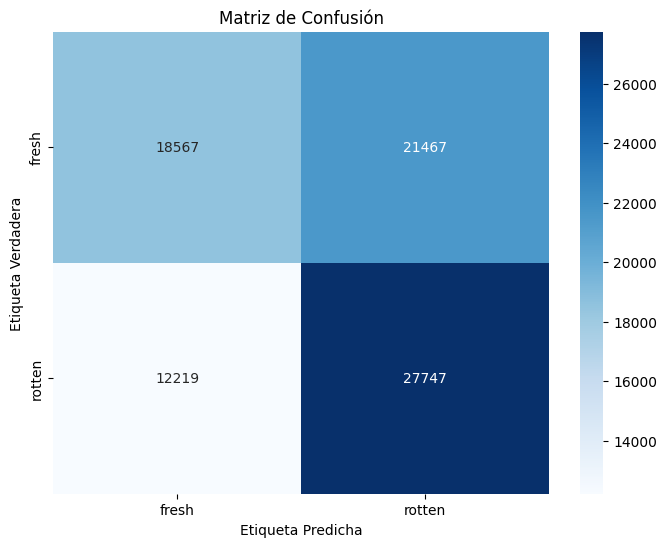

In [71]:
import time

for i, params in enumerate(param_sets):
    start_time = time.time()  # Registrar el tiempo de inicio
    
    # Crear una instancia del modelo RandomForestClassifier
    modelo_rf = RandomForestClassifier(**params)
    
    # Entrenar el modelo con los parámetros actuales

    modelo_rf.fit(xtrain, y_train)

    # Evaluar el rendimiento del modelo (por ejemplo, calcular la precisión)
    train_accuracy = modelo_rf.score(xtrain, y_train) * 100
    test_accuracy = modelo_rf.score(xtest, y_test) * 100

    
    end_time = time.time()  # Registrar el tiempo de finalización
    elapsed_time = end_time - start_time  # Calcular el tiempo transcurrido

    # Redondear el tiempo transcurrido a dos decimales
    elapsed_time = round(elapsed_time, 2)
    
    # Imprimir los resultados con el número de prueba, tiempo de ejecución y precisión en %
    print("Número de prueba:", i+1)
    print("Parámetros:", params)
    print("Precisión de entrenamiento:", "{:.2f}%".format(train_accuracy))
    print("Precisión de prueba:", "{:.2f}%".format(test_accuracy))
    print("Tiempo de ejecución :", elapsed_time, "segundos")
    print("--------------------------------------")
    
    # Calcular la matriz de confusión
    y_pred = modelo_rf.predict(xtest)
    cm = confusion_matrix(y_test, y_pred)

    labels = np.unique(y_test)
    df_cm = pd.DataFrame(cm, index=labels, columns=labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='d')
    plt.title("Matriz de Confusión")
    plt.xlabel("Etiqueta Predicha")
    plt.ylabel("Etiqueta Verdadera")
    plt.show()


# Árboles de decisión 🌳

### Pruebas con parámetros por defecto.

In [72]:
# Ajuste inicial del modelo
dt = DecisionTreeClassifier()
dt.fit(Xtrain, y_train)
y_pred_initial = dt.predict(Xtest)

# Matriz de confusión inicial
dt_initial = confusion_matrix(y_test, y_pred_initial)
dt_df_initial = pd.DataFrame(dt_initial)

# Precisión inicial
from sklearn.metrics import accuracy_score

dt_precision_initial = 100 * accuracy_score(y_test, y_pred_initial)
print('Precisión inicial: {0:.3f}%'.format(dt_precision_initial))

Precisión inicial: 64.446%


In [73]:
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report

# Generate a synthetic classification dataset

y_pred_train = dt.predict(Xtrain)
y_pred_test  = dt.predict(Xtest)

print(classification_report(y_train, y_pred_train))
print('----------------------------------------------------------')
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

       fresh       1.00      1.00      1.00      9930
      rotten       1.00      1.00      1.00     10070

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000

----------------------------------------------------------
              precision    recall  f1-score   support

       fresh       0.65      0.64      0.64     40034
      rotten       0.64      0.65      0.65     39966

    accuracy                           0.64     80000
   macro avg       0.64      0.64      0.64     80000
weighted avg       0.64      0.64      0.64     80000



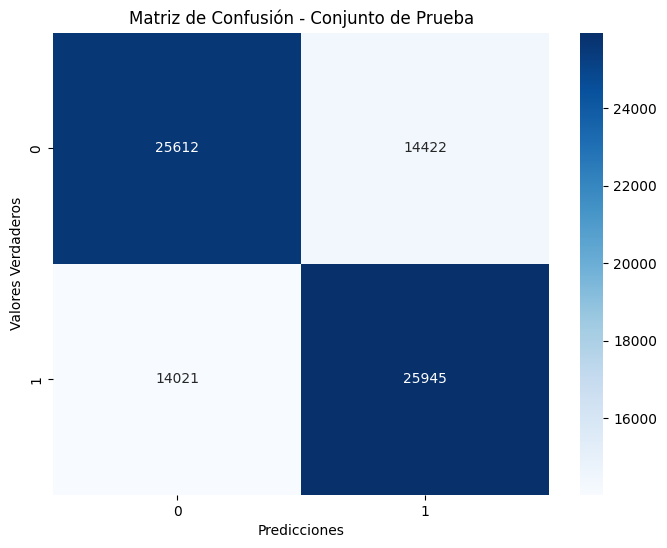

In [74]:
# Crear la matriz de confusión para el conjunto de prueba
cm_test = confusion_matrix(y_test, y_pred_test)

# Crear el mapa de calor para el conjunto de prueba
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, cmap="Blues",fmt='d')
plt.title("Matriz de Confusión - Conjunto de Prueba")
plt.xlabel("Predicciones")
plt.ylabel("Valores Verdaderos")
plt.show()

###  Prueba con los resultados de Features cuasi-constante

In [75]:
model = DecisionTreeClassifier(
    criterion='gini',max_depth=10,splitter='best'
)

In [76]:
model = DecisionTreeClassifier(
    criterion='gini',max_depth=10,splitter='best'
)

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2,4, 8, 10],
    'min_samples_leaf': [4, 2, 15],
    'max_features': ['auto', 'sqrt', 'log2']
}

grid_model_dt = GridSearchCV(
    estimator=model,
    param_grid = param_grid, 
    error_score="raise",
    refit=True,
    n_jobs=-1,
    cv=5,
)

In [77]:
grid_model_dt.fit(xtrain, y_train)

GridSearchCV(cv=5, error_score='raise',
             estimator=DecisionTreeClassifier(max_depth=10), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 5, 10],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [4, 2, 15],
                         'min_samples_split': [2, 4, 8, 10]})

In [78]:
grid_model_dt.best_params_

{'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 15,
 'min_samples_split': 10}

In [79]:
grid_model_dt.best_score_

0.5838

In [80]:
y_pred_train = grid_model_dt.predict(xtrain)
y_pred_test  = grid_model_dt.predict(xtest)
print(classification_report(y_train, y_pred_train))
print('----------------------------------------------------------')
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

       fresh       0.61      0.51      0.55      9930
      rotten       0.58      0.67      0.62     10070

    accuracy                           0.59     20000
   macro avg       0.59      0.59      0.59     20000
weighted avg       0.59      0.59      0.59     20000

----------------------------------------------------------
              precision    recall  f1-score   support

       fresh       0.59      0.48      0.53     40034
      rotten       0.56      0.66      0.61     39966

    accuracy                           0.57     80000
   macro avg       0.58      0.57      0.57     80000
weighted avg       0.58      0.57      0.57     80000



###  Selección de caracteristicas cuasi-constates y  Random FRE

In [81]:
grid_model_dt.fit(xtrainE, y_train)

GridSearchCV(cv=5, error_score='raise',
             estimator=DecisionTreeClassifier(max_depth=10), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 5, 10],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [4, 2, 15],
                         'min_samples_split': [2, 4, 8, 10]})

In [82]:
y_pred_train = grid_model_dt.predict(xtrainE)
y_pred_test  = grid_model_dt.predict(xtestE)
print(classification_report(y_train, y_pred_train))
print('----------------------------------------------------------')
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

       fresh       0.59      0.26      0.36      9930
      rotten       0.53      0.82      0.64     10070

    accuracy                           0.54     20000
   macro avg       0.56      0.54      0.50     20000
weighted avg       0.56      0.54      0.50     20000

----------------------------------------------------------
              precision    recall  f1-score   support

       fresh       0.57      0.26      0.36     40034
      rotten       0.52      0.81      0.63     39966

    accuracy                           0.53     80000
   macro avg       0.55      0.53      0.50     80000
weighted avg       0.55      0.53      0.50     80000



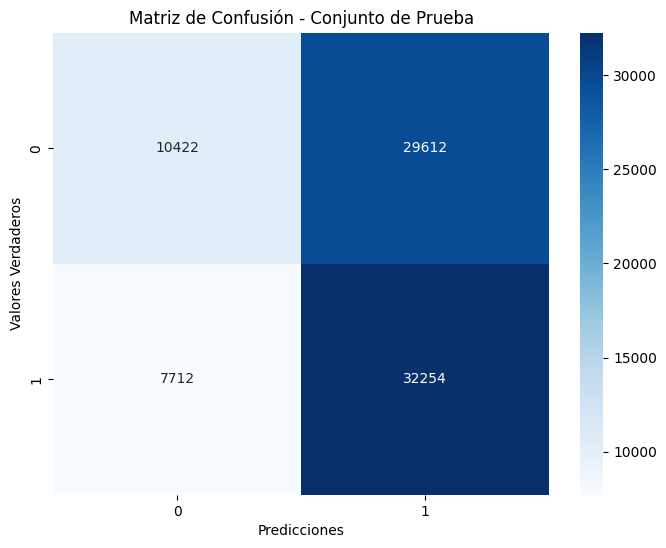

In [83]:
# Crear la matriz de confusión para el conjunto de prueba
cm_test = confusion_matrix(y_test, y_pred_test)

# Crear el mapa de calor para el conjunto de prueba
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, cmap="Blues",fmt='d')
plt.title("Matriz de Confusión - Conjunto de Prueba")
plt.xlabel("Predicciones")
plt.ylabel("Valores Verdaderos")
plt.show()

# Red neuronal  🧠

Precisión: 70.591%


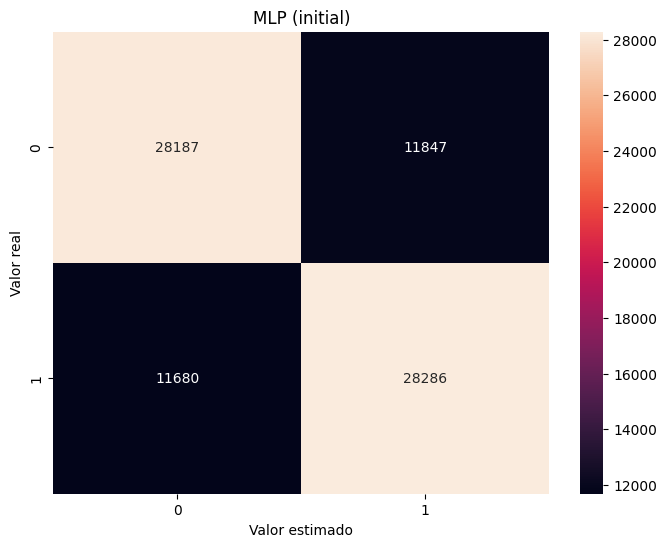

In [84]:
clf = MLPClassifier()
clf.fit(Xtrain, y_train)
y_pred = clf.predict(Xtest)
y_prob = clf.predict_proba(Xtest)

cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm)

mlp_precision = 100 * accuracy_score(y_test, y_pred)
print('Precisión: {0:.3f}%'.format(mlp_precision))

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d')
plt.title('MLP (initial)')
plt.ylabel('Valor real')
plt.xlabel('Valor estimado')
plt.show()


### Prueba redes neuronales con Feature cuasi-constantes

In [85]:
scaler = StandardScaler(with_mean=False)
xtrains = scaler.fit_transform(xtrain)
xtests = scaler.transform(xtest)

param_grid = {
    'hidden_layer_sizes': [(500),(700,500)],
    'max_iter': [15,20],
}

#500 & 1000 o más
# más neuronas >30
#fijar numero de iteraciones y jugar con la neuronas

grid = GridSearchCV(MLPClassifier(random_state=42), param_grid=param_grid, cv=2) # la profe recomendó 2
grid.fit(xtrains, y_train)
print(grid.best_params_)


{'hidden_layer_sizes': 500, 'max_iter': 15}


{'fresh': 0, 'rotten': 1}
Precisión de entrenamiento: 73.010%
Precisión de prueba: 56.463%
Tiempo de ejecución: 199.335 segundos


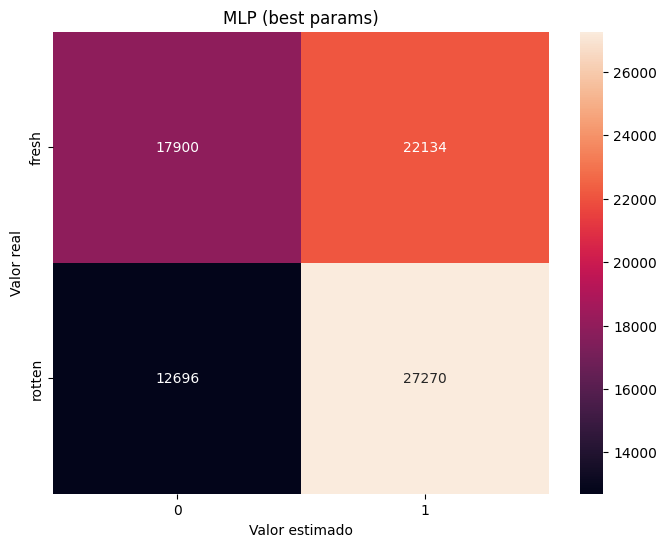

In [86]:
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix

start_time = time.time()

le = LabelEncoder()

# Ajustar el LabelEncoder a los datos de entrenamiento
le.fit(y_train)

clf = MLPClassifier(hidden_layer_sizes=(3000), max_iter=60)
clf.fit(xtrain, y_train)

y_pred = clf.predict(xtest)
y_prob = clf.predict_proba(xtest)

mapping = dict(zip(le.classes_, range(0, len(le.classes_))))
print(mapping)

cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=mapping)

train_accuracy = clf.score(xtrain, y_train) * 100
test_accuracy = clf.score(xtest, y_test) * 100

end_time = time.time()
elapsed_time = end_time - start_time

print("Precisión de entrenamiento: {:.3f}%".format(train_accuracy))
print("Precisión de prueba: {:.3f}%".format(test_accuracy))
print("Tiempo de ejecución: {:.3f} segundos".format(elapsed_time))

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True ,fmt='d')
plt.title('MLP (best params)')
plt.ylabel('Valor real')
plt.xlabel('Valor estimado')
plt.show()


# Red neuronal profunda Keras

In [89]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow import keras

def create_model():
    model = keras.models.Sequential([
        keras.layers.Dense(4000, activation='relu', input_shape=(xtestE.shape[1],)),
        keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])
    return model

# Crear el objeto KerasClassifier
keras_classifier = KerasClassifier(build_fn=create_model)

# Ajustar el modelo sin GridSearchCV
keras_classifier.fit(xtrainE, y_train)

# Obtener el modelo entrenado
best_model = keras_classifier.model

# Realizar predicciones en los datos de prueba
y_pred = best_model.predict(xtestE)

2500/2500 [==============================] - 7s 3ms/step


# Resultados obtenidos

A continuación se muestran los resultados de las pruebas donde se obtuvo una mejor precisión.



 En las primeras pruebas,sin aplicar seleccion de caracteristicas y con parametros por defecto, Los resultados indican que los modelos tienen dificultades para generalizar adecuadamente a los datos no vistos, Esto nos sugiere que los modelos se están sobreajustando a los datos de entrenamiento, ya que alcanzan una precisión cercana al 100% en el conjunto de entrenamiento pero una precisión un poco menor en el conjunto de prueba. con estos resultados podemos anticipar que el modelo tendra mal rendimiento cuando sea probado con datos no conocidos.


en las segundas pruebas, con seleccion de caracteristicas cuasi-constantes, notamos que Al eliminar las características cuasi-constantes el rendimiento del modelo disminuye aún más. Esto nos puede indicar que algunas de las características consideradas cuasi-constantes podrían contener  información valiosa para la tarea de clasificación y al eliminarlas, la capacidad del modelo para generalizar a nuevos datos disminuye.


Al aplicar una segunda selección de características con Random Forest en las últimas pruebas de cada modelo, se observa que el rendimiento de los modelos disminuye tanto en el conjunto de entrenamiento como en el conjunto de prueba.
se está produciendo el underfitting, que es cuando el modelo no logra capturar las relaciones y patrones  presentes en los datos. la selección de características con Random Forest podría estar eliminado características importantes o relevantes para el problema, lo que explicaría el bajo rendimiento en los modelos.










# Sugerencias para mejorar el trabajo

En la exploración de esta actividad se pudo obsevar que se hace necesario:

* Realizar el entrenamiento de los modelos con mucho mas datos.
* Explorar mas los hiperparametros de los modelos junto con los umbrales de las 
  selecciones de caracteristicas.
* Contar con recursos computacionales optimos para hacer las pruebas con mayor 
  cantidad de datos.
aplicando correctamente las actividades anteriores, los modelos aumentaran la precisión a la hora de clasificar los comentarios rotten y fresh.

# Bibliografía

* https://www.cienciadedatos.net/documentos/py25-text-mining-python.html
* https://www.kaggle.com/code/hariharanalm/rt-reviews-classification-with-lstm
